In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-28 14:11:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-28 14:11:59 (82.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
import tensorflow as tf
import helper_functions as hf
import pandas as pd
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

## 2022.07.10 - Skimlit Part 2
- Problem:
  - 文章摘要, 將each sentnece 分配到某一段落(label)
- Many to one
  - logically to determine the type of problem. like only extract one label that have highest prob. from multiple labels
- Reference:
  - Model: https://arxiv.org/pdf/1612.05251.pdf
  - Dataset: https://arxiv.org/pdf/1710.06071.pdf

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-219d1820-a924-c83b-3404-71cb50579a64)


### Get Data
- https://github.com/Franck-Dernoncourt/pubmed-rct.git

In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls ./pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
dev.txt  test.txt  train.txt


In [5]:
import os 
data_dir = "./pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filepaths = sorted([data_dir+filepath for filepath in os.listdir(data_dir)])
filepaths

['./pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [16]:
def get_lines(filename):
  lines = []
  with open(filename,"r") as f:
    lines = f.readlines()
  return lines

### Preprocessing the data
- to convert to the following format for each line
- if want to count the total line number, the line number is starting from 0
  - record line number and total line number for each group of text with ID
```
[{
  'line_number':0,
  'target':'OBJECTIVE',
  'text':'...',
  'total_lines':11
}..]
```

In [7]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_id = ""
  abstract_line = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line.replace("###","").replace("\n","")
      abstract_line = "" # emtpy the abstract line for each group
    elif line.isspace(): # only contain \n. then record the data in thie gorup with ID
      abstract_line_list = abstract_line.splitlines()

      for line_num, abstract_line in enumerate(abstract_line_list):
        data = {}
        data["line_num"] = line_num
        data["target"] = abstract_line.split("\t")[0]
        data["text"] = abstract_line.split("\t")[1].lower()
        data["total_lines"] = len(abstract_line_list) - 1 # line numbers is count with index 0
        data["ID"] = abstract_id 
        abstract_samples.append(data)
    
    else:
      abstract_line+=line
  
  return abstract_samples

In [8]:
train_data = preprocess_text_with_line_numbers(filepaths[2])
test_data = preprocess_text_with_line_numbers(filepaths[1]) 
dev_data = preprocess_text_with_line_numbers(filepaths[0])

In [9]:
len(train_data),len(test_data),len(dev_data)

(180040, 30135, 30212)

In [10]:
train_data[:1]

[{'ID': '24293578',
  'line_num': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11}]

In [11]:
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(dev_data)
test_df = pd.DataFrame(test_data)

In [12]:
# see the dist of labels
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

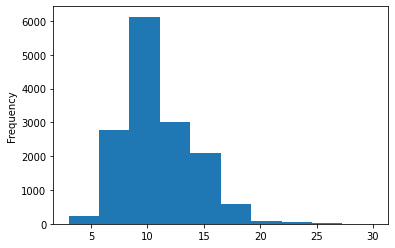

In [13]:
# see the dist of sentences in a paragraph (1 paragraph with 1 ID)
train_df[["ID","total_lines"]].drop_duplicates()["total_lines"].plot.hist()

### Convert Target Label to Numbers
- onehotencode 
- labelencode

In [145]:
## prepare input
train_sentence = train_df["text"].to_numpy()
val_sentence = val_df["text"].to_numpy()
test_sentence = test_df["text"].to_numpy()

In [146]:
# one hot encoding
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_label_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_label_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_label_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

In [147]:
tf.constant(train_label_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [148]:
# label encode
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_label_encode = label_encoder.fit_transform(train_df["target"].to_numpy())
val_label_encode = label_encoder.transform(val_df["target"].to_numpy())
test_label_encode = label_encoder.transform(test_df["target"].to_numpy())
print(train_label_encode[:10])
class_names = label_encoder.classes_
len(class_names),class_names

[3 2 2 2 2 2 4 4 4 4]


(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Model 0 - Baseline Model
- Naive bayes

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [25]:
model_0 = Pipeline([
      ("tfidfVectorizer",TfidfVectorizer()),
      ("MultinomialNB",MultinomialNB())
])

In [26]:
history_0 = model_0.fit(X=train_sentence,
             y=train_label_encode)

In [27]:
history_0

Pipeline(steps=[('tfidfVectorizer', TfidfVectorizer()),
                ('MultinomialNB', MultinomialNB())])

In [ ]:
model_0.score(val_sentence,val_label_encode)

0.7218323844829869

In [ ]:
model_0_pred = model_0.predict(val_sentence)
model_0_result = hf.calculate_results(val_label_encode,model_0_pred)


## 2022.07.11 - SkimLit Part 2

In [ ]:
train_sentence

array(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
       'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       ...,
       'both strategies had acceptable side effect profiles , with a low incidence oflaboratory abnormalities and cardiovascular events .',
       'compared with standard statin monotherapy , the combination of statin plus ezetimibe showed greater coronary plaque regression , which might be attributed to cholesterol absorption inhibition-induced aggressive lipid lowering .',
       '( plaque regression with cholesterol abs

### Tokenization
- but need to know which output length for each sentence might be better
- to check which number of token can avoid 95% setence to be cutoff

In [ ]:
train_sentence

array(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
       'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       ...,
       'both strategies had acceptable side effect profiles , with a low incidence oflaboratory abnormalities and cardiovascular events .',
       'compared with standard statin monotherapy , the combination of statin plus ezetimibe showed greater coronary plaque regression , which might be attributed to cholesterol absorption inhibition-induced aggressive lipid lowering .',
       '( plaque regression with cholesterol abs

26.338269273494777


(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

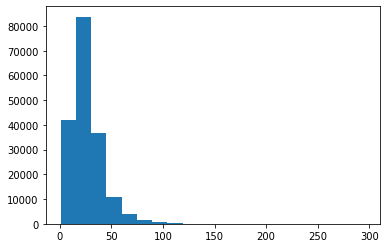

In [153]:
word_len_list = [len(sentence.split()) for sentence in train_sentence]
print(np.mean(word_len_list))
plt.hist(word_len_list,bins=20)

In [154]:
output_seq_length = int(np.percentile(word_len_list,95))
output_seq_length

55

In [155]:
# refer to paper to check the tokens in volcabulary for 20K (https://arxiv.org/pdf/1710.06071.pdf)
text_vectorizor = TextVectorization(
    max_tokens = 68000,
    output_sequence_length = output_seq_length
) 

In [156]:
text_vectorizor.adapt(train_sentence)

In [ ]:
import random
random_sentence = random.choice(train_sentence)
print("word's length:",len(random_sentence))
print("text:", random_sentence)
print("text vectorizer:",text_vectorizor([random_sentence]))

word's length: 60
text: blind assessments were done at baseline , @ , and @ months .
text vectorizer: tf.Tensor(
[[1457  657    9 1223   15   49    3   41    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)


In [158]:
# volcabulary only put unique token
volcab = text_vectorizor.get_vocabulary()
print(len(volcab)) # show unique words not thee max token
print(volcab[:5])
print(volcab[-5:])

64841
['', '[UNK]', 'the', 'and', 'of']
['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizor.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [159]:
embedding = Embedding(
    input_dim=len(volcab),
    output_dim=128,
    input_length = output_seq_length,
    mask_zero = True, # the index [0,:] in embedding layer cannot be used. so all tokens will be shift down one step
    name = "token_embedding"
)

In [ ]:
import random
random_sentence = random.choice(train_sentence)
print("word's length:",len(random_sentence))
print("text:", random_sentence)
print("text vectorizer:",text_vectorizor([random_sentence]))
print("embedding words:",embedding(text_vectorizor([random_sentence])))

word's length: 231
text: in this prospective , open-label , randomized , controlled trial ( isrctn@ ) with a selected crossover phase , patients with cancer-related pain were randomized to receive either oral morphine or oxycodone as first-line treatment .
text vectorizer: tf.Tensor(
[[   5   23  241  570   29  106   32  811    7    8  630  484  209   12
     7 4603   65    9   29    6  175  132  217  961   16 3873   25 1368
    19    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)
embedding words: tf.Tensor(
[[[ 0.04657799  0.02207843  0.04639745 ... -0.04929847  0.00362352
    0.01067179]
  [-0.02828399  0.03328811  0.01931726 ... -0.04711009 -0.01415078
    0.0192141 ]
  [-0.04022174 -0.03853367 -0.00490109 ...  0.01913876  0.01045772
    0.00656792]
  ...
  [ 0.03450679  0.04595012  0.02093807 ...  0.00557341  0.01129954
    0.0106135 ]
  [ 0.03450679  0.04595012  0.02093

### Feature engineering pipeline
- tf.dataset api
- can utilize the resource and improve the efficiency in tensorflow

In [149]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentence,train_label_one_hot))
validation_dataset = tf.data.Dataset.from_tensor_slices((val_sentence,val_label_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentence,test_label_one_hot))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [151]:
# prefetch: not load 32 samples at a time, 而是 盡可能去撈多一點sample在 memory first and provide to GPU run the computing
# and no shuffle becasue it is not meaningful because sequence is important
train_dataset_prefetch = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset_prefetch = validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_prefetch = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset_prefetch

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1 - Conv1D

In [182]:
inputs = tf.keras.layers.Input(shape=[],dtype=tf.string)
text_vector = text_vectorizor(inputs)
embedding_vector = embedding(text_vector)
x = tf.keras.layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(embedding_vector)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(len(class_names),activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs)

In [183]:
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [184]:
model_1.fit(train_dataset_prefetch,
            # epoch 裡面沒辦法go through all the data, but can go through all data across different epochs
            steps_per_epoch = int(0.3*len(train_dataset_prefetch)),
            epochs=3,
            validation_data = val_dataset_prefetch,
            validation_steps = int(0.3*len(val_dataset_prefetch)),
            callbacks = [model_checkpoint = ModelCheckpoint(monitor='val_loss',
                                    filepath=f'./models/HDF5/best-model.h5',
                                    save_best_only=True,
                                    verbose=1,
                                    save_format='tf')])

Epoch 1/3
1684/1688 [============================>.] - ETA: 0s - loss: 0.5008 - accuracy: 0.8242
Epoch 1: val_loss improved from inf to 0.54096, saving model to .best-model.h5


NotImplementedError: ignored

In [ ]:
model_1.save("total_fileformat.h5")

In [ ]:
len(train_dataset_prefetch)

5627

In [ ]:
model_1.evaluate(val_dataset_prefetch)

945/945 [==============================] - 3s 3ms/step - loss: 0.5434 - accuracy: 0.8053


[0.5434281229972839, 0.8052760362625122]

In [ ]:
model_1_pred = tf.argmax(model_1.predict(val_sentence),axis=1)
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_result = hf.calculate_results(val_label_encode,model_1_pred)
model_1_result

{'accuracy': 80.52760492519528,
 'f1': 0.7990071725894369,
 'precision': 0.8102705863206875,
 'recall': 0.8052760492519528}

### Model 2 - Pre-trained embedding
- GoV embedding layers

In [ ]:
import tensorflow_hub as hub

In [164]:
use = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
               trainable=False,
               input_shape=[])

In [165]:
inputs = tf.keras.layers.Input(shape=[],dtype=tf.string)
x = use(inputs)
x = tf.keras.layers.Dense(128,activation="relu")(x)
outputs = tf.keras.layers.Dense(len(class_names),activation="softmax")(x)
model_2 = tf.keras.Model(inputs,outputs)

In [166]:
model_2.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None,)]                 0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_24 (Dense)            (None, 128)               65664     
                                                                 
 dense_25 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [167]:
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [168]:
history_2 = model_2.fit(train_dataset_prefetch,
            # epoch 裡面沒辦法go through all the data, but can go through all data across different epochs
            steps_per_epoch = int(0.1*len(train_dataset_prefetch)),
            epochs=3,
            validation_data = val_dataset_prefetch,
            validation_steps = int(0.1*len(val_dataset_prefetch)))

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9155 - accuracy: 0.6513 - val_loss: 0.7953 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7698 - accuracy: 0.7018 - val_loss: 0.7549 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7535 - accuracy: 0.7109 - val_loss: 0.7404 - val_accuracy: 0.7104


In [169]:
model_2.save("total.h5")

In [171]:
import tensorflow as tf

In [172]:
tf.__version__

'2.8.2'

In [170]:
from google.colab import files
files.download("total.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_2.evaluate(val_dataset_prefetch)

945/945 [==============================] - 11s 12ms/step - loss: 0.7444 - accuracy: 0.7128


[0.7443907260894775, 0.7128293514251709]

In [ ]:
model_2_pred = tf.argmax(model_2.predict(val_sentence),axis=1)
model_2_result = hf.calculate_results(val_label_encode,model_2_pred)
model_2_result

{'accuracy': 71.28293393353634,
 'f1': 0.709811799519593,
 'precision': 0.7127891102083233,
 'recall': 0.7128293393353634}

## 2022.07.12 - SkimLit Part 3

### Conv1D with character embedding
- make character to word so that can use TextVectorizer

In [29]:
## Prepare the character that will be viewed as work for tokenization
def split_chars(str_):
  return " ".join(list(str_))

In [ ]:
train_sentence

array(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
       'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       ...,
       'both strategies had acceptable side effect profiles , with a low incidence oflaboratory abnormalities and cardiovascular events .',
       'compared with standard statin monotherapy , the combination of statin plus ezetimibe showed greater coronary plaque regression , which might be attributed to cholesterol absorption inhibition-induced aggressive lipid lowering .',
       '( plaque regression with cholesterol abs

In [30]:
train_chars_sentence = list(map(split_chars,train_sentence))
val_chars_sentence = list(map(split_chars,val_sentence))
test_chars_sentence = list(map(split_chars,test_sentence))
char_len_list = list(map(lambda x:len(x.split()),train_chars_sentence))
train_chars_sentence[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

124.02798822483892
239


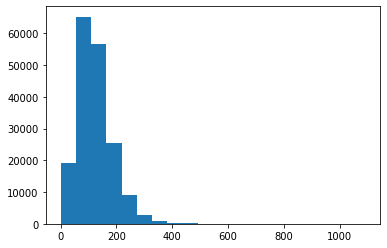

In [ ]:
## determine the char-level output max length
print(np.mean(char_len_list))
plt.hist(char_len_list,bins=20)
output_max_length = int(np.percentile(char_len_list,95))
print(output_max_length)

In [ ]:
## tokenization 
import string
# because we are using the char-based tokenization so the distinct token for char might not be too much.
maxtokens = string.ascii_lowercase + string.digits + string.punctuation
print(maxtokens)
char_vectorizer = TextVectorization(
    max_tokens = len(maxtokens)+2, # for the space and OOV token
    output_sequence_length = output_max_length
)
char_vectorizer.adapt(train_chars_sentence)

abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
volcab = char_vectorizer.get_vocabulary()
len(volcab)

28

In [ ]:
# check the sample
import random
random_char_sentence = random.choice(train_chars_sentence)
print(random_char_sentence)
print(char_vectorizer([random_char_sentence]))
print(char_vectorizer([random_char_sentence]).shape)

o t h e r   p h a r m a c o k i n e t i c   p a r a m e t e r s   i n c l u d i n g   t h e   p l a s m a   a u c   ,   e l i m i n a t i o n   h a l f - l i f e   ,   a n d   t o t a l   b o d y   c l e a r a n c e   e x h i b i t e d   s i m i l a r   v a l u e s   w i t h o u t   a   s i g n i f i c a n t   d i f f e r e n c e   .


NameError: ignored

In [ ]:
### embedding
char_embeddings = Embedding(
    input_dim = len(volcab) + 1,
    output_dim = 25, # refer to the paper, the output dim of character embedding should 25
    mask_zero = True
)

In [ ]:
# check the sample
import random
random_char_sentence = random.choice(train_chars_sentence)
print(random_char_sentence)
print(char_vectorizer([random_char_sentence]))
print(char_vectorizer([random_char_sentence]).shape)
print(char_embeddings(char_vectorizer([random_char_sentence])))
print(char_embeddings(char_vectorizer([random_char_sentence])).shape)

t h i s   i s   p a r t i c u l a r l y   v a l u a b l e   i n   s i t u a t i o n s   i n v o l v i n g   c o m p l e x   v i s u a l   s u b j e c t   m a t t e r s   ,   t y p i c a l   i n   c l i n i c a l   p r a c t i c e   .
tf.Tensor(
[[ 3 13  4  9  4  9 14  5  8  3  4 11 16 12  5  8 12 19 21  5 12 16  5 22
  12  2  4  6  9  4  3 16  5  3  4  7  6  9  4  6 21  7 12 21  4  6 18 11
   7 15 14 12  2 24 21  4  9 16  5 12  9 16 22 27  2 11  3 15  5  3  3  2
   8  9  3 19 14  4 11  5 12  4  6 11 12  4  6  4 11  5 12 14  8  5 11  3
   4 11  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]], shape=(1, 239),

In [ ]:
# model
inputs = tf.keras.layers.Input(shape=[1],dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeded = char_embeddings(char_vectors)
x = tf.keras.layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(char_embeded)
x = tf.keras.layers.GlobalMaxPool1D()(x) # MaxPolling got better performance then globally polling
outputs = tf.keras.layers.Dense(len(class_names),activation="softmax")(x)
model_3 = tf.keras.Model(inputs,outputs)

In [ ]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 239)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 239, 25)           725       
                                                                 
 conv1d_1 (Conv1D)           (None, 239, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [ ]:
model_3.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars_sentence,train_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars_sentence,val_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars_sentence,test_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
len(train_char_dataset),train_char_dataset

(5627,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_3 = model_3.fit(train_char_dataset,
                        steps_per_epoch=int(0.1*len(train_char_dataset)),
                        epochs=3,
                        validation_data=val_char_dataset,
                        validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 5ms/step - loss: 1.2647 - accuracy: 0.4954 - val_loss: 1.0378 - val_accuracy: 0.5941
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9970 - accuracy: 0.6031 - val_loss: 0.9168 - val_accuracy: 0.6403
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9188 - accuracy: 0.6406 - val_loss: 0.8534 - val_accuracy: 0.6709


In [ ]:
model_3_pred = tf.argmax(model_3.predict(val_char_dataset),axis=1)
model_3_result = hf.calculate_results(val_label_encode,model_3_pred)
model_3_result

{'accuracy': 66.06315371375612,
 'f1': 0.6509042921434346,
 'precision': 0.6547370089799684,
 'recall': 0.6606315371375613}

### Concatenate Token & Char emmbeddings
- combine model_2's token(word) embedding + model_3's char embedding
- model_2 token embedding is tensorflow hub
- reference:
  - https://medium.com/airbnb-engineering/widetext-a-multimodal-deep-learning-framework-31ce2565880c

In [ ]:
# token embedding
token_inputs = tf.keras.layers.Input(shape=[],dtype=tf.string)
token_embedding = use(token_inputs)
token_outputs = tf.keras.layers.Dense(128,activation="relu")(token_embedding)
token_model = tf.keras.Model(token_inputs,token_outputs)

# char embedding
char_inputs = tf.keras.layers.Input(shape=[1,],dtype=tf.string)
char_vector = char_vectorizer(char_inputs)
char_embedding = char_embeddings(char_vector)
char_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(char_inputs,char_outputs)

# concatenate, append vector, only can put the tensor inside the concatenate methood
token_char_concat = tf.keras.layers.concatenate((token_outputs,
                                                 char_outputs),axis=1)

# combine together
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense_layer = tf.keras.layers.Dense(128,activation="relu")(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense_layer)
outputs = tf.keras.layers.Dense(len(class_names),activation="softmax")(final_dropout)
# use reference model object to combine the model to a siingle one hybrid model
model_4 = tf.keras.Model([token_model.inputs,
                          char_model.inputs],outputs)

In [ ]:
model_4.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 239)         0           ['input_5[0][0]']                
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['input_4[0][0]']          

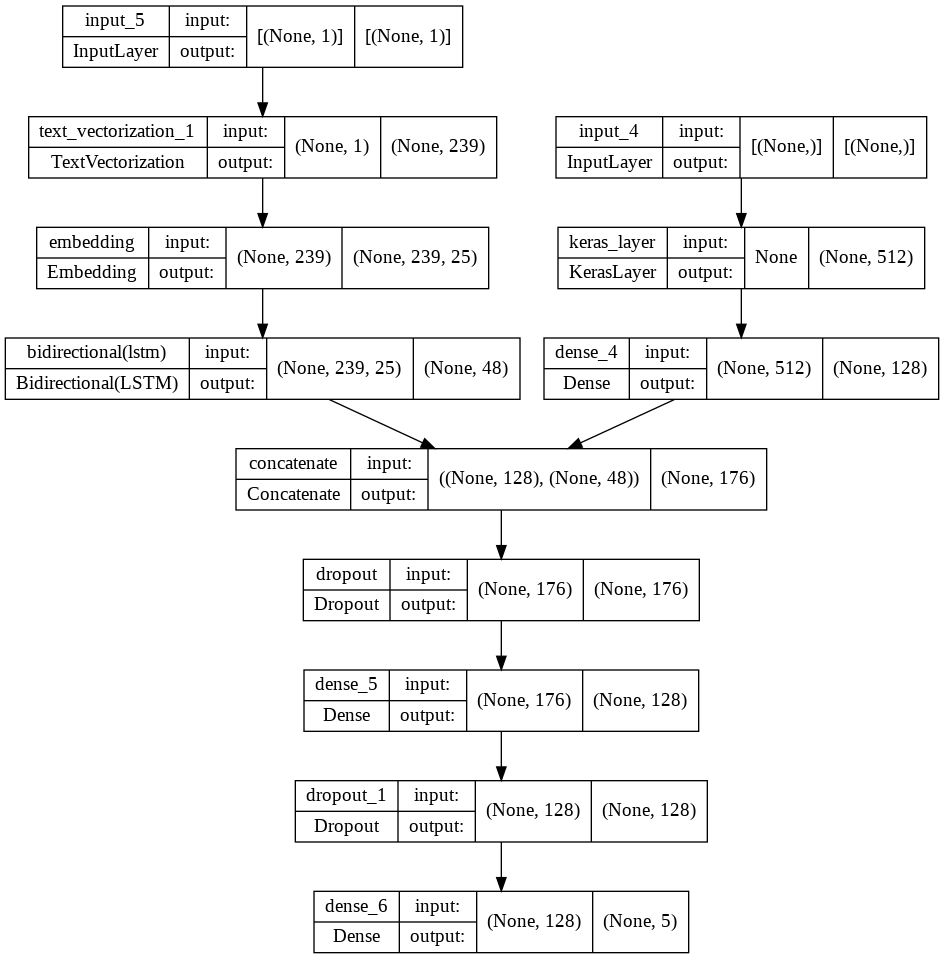

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4,show_shapes=True)

### Prepare multi-input with tf.Data API

### Model 4 - Combine token/char embed
- the order between model's input and combined feature dataset should be same

In [ ]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentence,train_chars_sentence))
train_token_char_label = tf.data.Dataset.from_tensor_slices(train_label_one_hot)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data,train_token_char_label)).batch(32).prefetch(tf.data.AUTOTUNE)

val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentence,val_chars_sentence))
val_token_char_label = tf.data.Dataset.from_tensor_slices(val_label_one_hot)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data,val_token_char_label)).batch(32).prefetch(tf.data.AUTOTUNE)

test_token_char_data = tf.data.Dataset.from_tensor_slices((test_sentence,test_chars_sentence))
test_token_char_label = tf.data.Dataset.from_tensor_slices(test_label_one_hot)
test_token_char_dataset = tf.data.Dataset.zip((test_token_char_data,test_token_char_label)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
len(train_token_char_dataset)

5627

In [ ]:
### Modeling
history_4 = model_4.fit(train_token_char_dataset,
                        steps_per_epoch=int(0.1*len(train_token_char_dataset)),
                        epochs=3,
                        validation_data=val_token_char_dataset,
                        validation_steps=int(0.1*len(val_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 38s 52ms/step - loss: 0.9851 - accuracy: 0.6028 - val_loss: 0.7857 - val_accuracy: 0.6998
Epoch 2/3
562/562 [==============================] - 27s 49ms/step - loss: 0.8072 - accuracy: 0.6861 - val_loss: 0.7203 - val_accuracy: 0.7287
Epoch 3/3
562/562 [==============================] - 24s 44ms/step - loss: 0.7810 - accuracy: 0.7012 - val_loss: 0.6966 - val_accuracy: 0.7387


In [ ]:
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 34s 36ms/step - loss: 0.6991 - accuracy: 0.7341


[0.6990760564804077, 0.7340791821479797]

In [ ]:
model_4_pred = tf.argmax(model_4.predict(val_token_char_dataset),axis=1)

In [ ]:
model_4_result = hf.calculate_results(val_label_encode,model_4_pred)
model_4_result

{'accuracy': 73.407917383821,
 'f1': 0.7310988680461763,
 'precision': 0.7379414118674553,
 'recall': 0.73407917383821}

### Notes
- Steps per epoch, each epoch will go through the remaining unhandled batches
- max pooling have better performance than average pooling
- tf.keras.layeers.concatenate() only can put the tensor in the methood
- model is layer, layer is model. a model can contains multiple sub-model
- tf.keras.Model([input1,input2]) can put multiple input to construcut multi-input model
- if want convert multi-input data to tensorflow dataset with its label
  - then need to convert data,label separately using from_tensor_slices
  - then zip the data and labe lateer

## 2022.07.13 - SkimLit Part 4

### Model 5 - Feature engineeering - Position embedding
- the sequence of setnences in the paragraph is important
- feature engineering:
  - traininig do which feature engineering basically test/val need to follow the same feature engineering with training setting but not necessay like data augmentation. 
  - But for this case is need. the test/val input need to be a abstract so that we can get line_numbers and total_line numbers
  - encode the line_numbers and total_line_numbers
    - one_hot: why becuase it is like categorical feature so model won't know 4 is 2*2 so make it one_hot but just limited one hot for high-cardinality problem
    - only set the appropriate depth that contains most of samples and the remaining samples will have all 0's feature vector

15.0

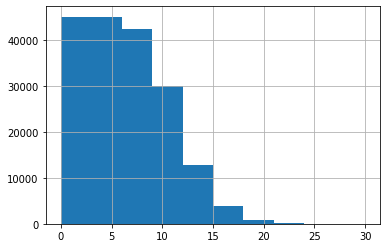

In [ ]:
## Feature engineering line_number and total_line_numbers
train_df["line_num"].hist()
np.percentile(train_df["line_num"],98)

In [ ]:
train_line_num_one_hot = tf.one_hot(train_df["line_num"].to_numpy(),depth=15)
val_line_num_one_hot = tf.one_hot(val_df["line_num"].to_numpy(),depth=15)
test_line_num_one_hot = tf.one_hot(test_df["line_num"].to_numpy(),depth=15)
train_line_num_one_hot.shape

TensorShape([180040, 15])

20.0

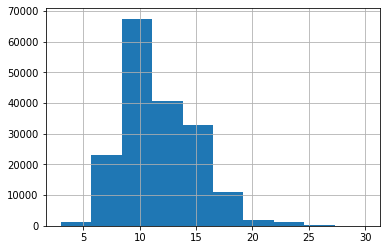

In [ ]:
train_df["total_lines"].hist()
np.percentile(train_df["total_lines"],98)

In [ ]:
train_total_line_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_line_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_line_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)
train_total_line_one_hot.shape

TensorShape([180040, 20])

### Model 5 - Tribrid Embedding
- concatenate(token+char embedding)
- line-numbers embeding
- total-line-numbers embedding

In [ ]:
### Modeling
# token model
token_inputs = tf.keras.layers.Input(shape=[],dtype=tf.string)
token_embeddings = use(token_inputs)
token_outputs = tf.keras.layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs,
                             token_outputs,
                             name="token_model")

# char model
char_inputs = tf.keras.layers.Input(shape=[1],dtype=tf.string)
char_vectors = char_vectorizer(char_inputs)
x = char_embeddings(char_vectors)
char_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(x)
char_model =tf.keras.Model(char_inputs,
                           char_outputs,
                           name="char_model")
# line num model
line_number_inputs = tf.keras.layers.Input(shape=[15],dtype=tf.float32)
line_number_outputs = tf.keras.layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,
                                          line_number_outputs,
                                          name="line_number_model")
# total line num model
total_line_inputs = tf.keras.layers.Input(shape=[20],dtype=tf.float32)
total_line_outputs = tf.keras.layers.Dense(32,activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs,
                                          total_line_outputs,
                                         name="total_line_model")
# combine token and char outputs
combined_embedding = tf.keras.layers.concatenate([char_outputs,token_outputs])
z = tf.keras.layers.Dense(256,activation="relu")(combined_embedding)
z = tf.keras.layers.Dropout(0.5)(z)

# combinne (token+char) outptus and line and total
pos_char_token_embedding = tf.keras.layers.concatenate([z,
                                                        line_number_outputs,
                                                        total_line_outputs])

outputs = tf.keras.layers.Dense(len(class_names),activation="softmax")(pos_char_token_embedding)
model_5 = tf.keras.Model([token_model.input,
                          char_model.input,
                          line_number_model.input,
                          total_line_model.input],
                         outputs,
                         name="tribid_embedding_modoel")

In [ ]:
# label smoothiing a way to avoid overfitting to make it be general. it will assign the highest prob of class to other classes 
# to make it reasonable
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

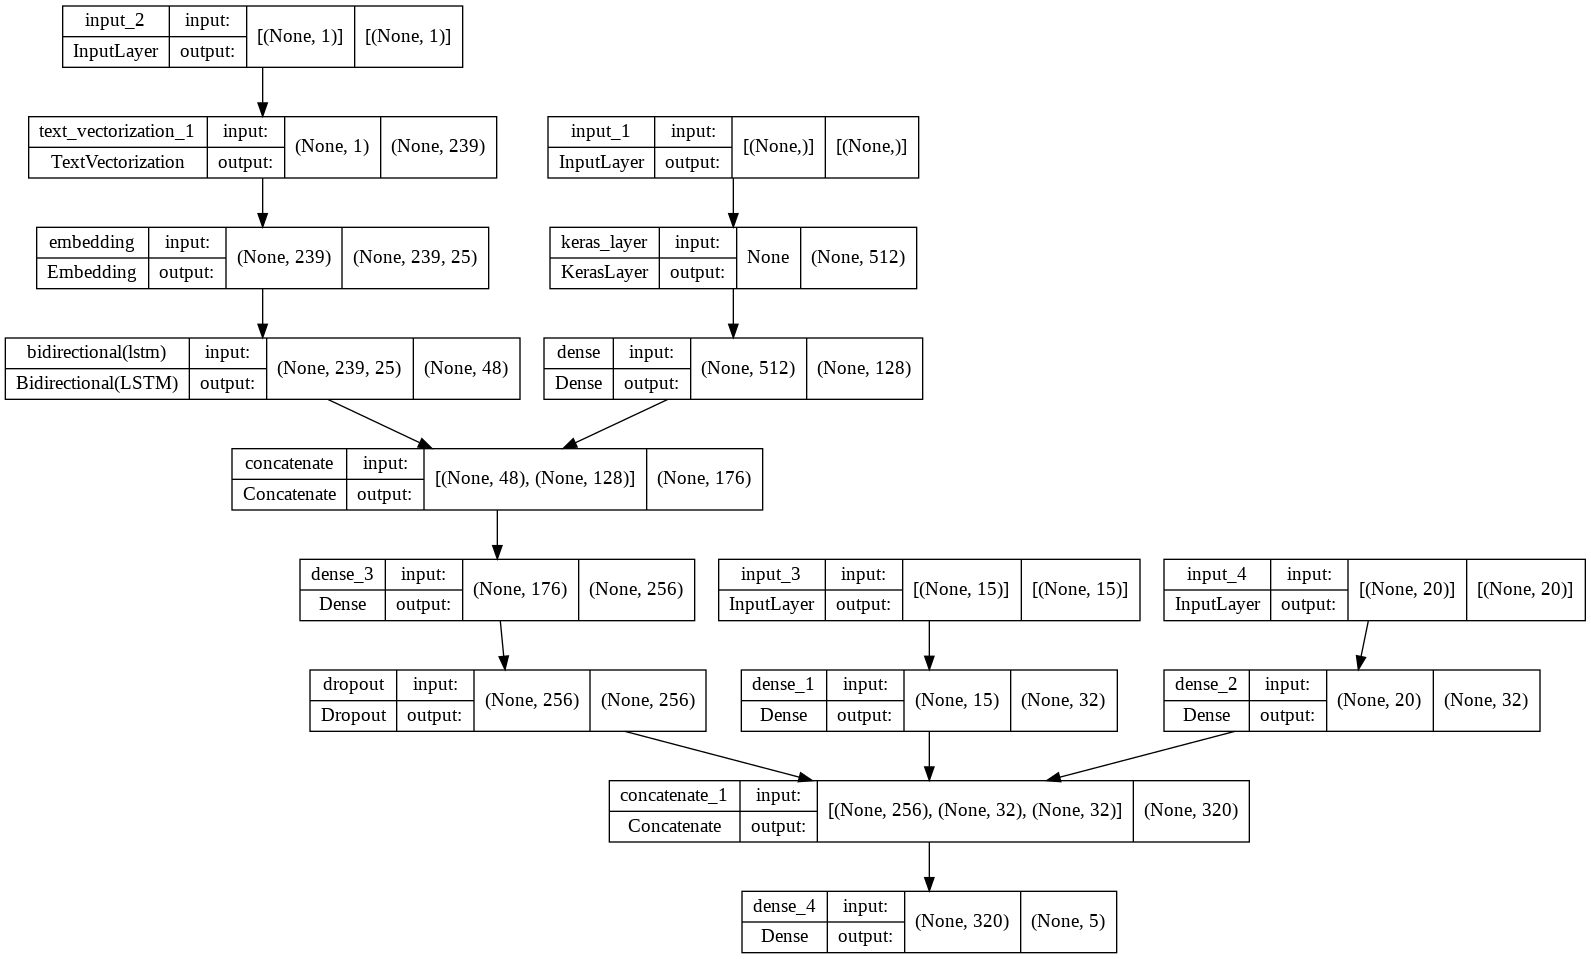

In [ ]:
plot_model(model_5,show_shapes=True)

### Model 5 : Turn dataset to tensorflow dataset
- fast loading

In [ ]:
# train
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentence,
                                                                train_chars_sentence,
                                                                train_line_num_one_hot,
                                                                train_total_line_one_hot))
train_pos_char_token_label = tf.data.Dataset.from_tensor_slices(train_label_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data,train_pos_char_token_label)).batch(32).prefetch(tf.data.AUTOTUNE)


#val
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentence,
                                                                val_chars_sentence,
                                                                val_line_num_one_hot,
                                                                val_total_line_one_hot))
val_pos_char_token_label = tf.data.Dataset.from_tensor_slices(val_label_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data,val_pos_char_token_label)).batch(32).prefetch(tf.data.AUTOTUNE)


#test
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentence,
                                                                test_chars_sentence,
                                                                test_line_num_one_hot,
                                                                test_total_line_one_hot))
test_pos_char_token_label = tf.data.Dataset.from_tensor_slices(test_label_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data,test_pos_char_token_label)).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_pos_char_token_data

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(15,), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None))>

### Model 5 - Training and evaluation

In [ ]:
history_5 = model_5.fit(
    train_pos_char_token_dataset,
    steps_per_epoch = int(0.3*len(train_pos_char_token_dataset)),
    epochs = 3,
    validation_data = val_pos_char_token_dataset,
    validation_steps = int(0.3*len(val_pos_char_token_dataset))
)

Epoch 1/3
1688/1688 [==============================] - 101s 50ms/step - loss: 1.0063 - accuracy: 0.7861 - val_loss: 0.9344 - val_accuracy: 0.8331
Epoch 2/3
1688/1688 [==============================] - 76s 45ms/step - loss: 0.9395 - accuracy: 0.8320 - val_loss: 0.9164 - val_accuracy: 0.8457
Epoch 3/3
1688/1688 [==============================] - 83s 49ms/step - loss: 0.9271 - accuracy: 0.8405 - val_loss: 0.9189 - val_accuracy: 0.8431


In [ ]:
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.9173 - accuracy: 0.8466


[0.9173175096511841, 0.8466172218322754]

In [ ]:
model_5_pred = tf.argmax(model_5.predict(val_pos_char_token_dataset),axis=1)
model_5_pred_result = hf.calculate_results(val_label_encode,model_5_pred)
model_5_pred_result

{'accuracy': 84.66172381835032,
 'f1': 0.8424001551691318,
 'precision': 0.8519202938211861,
 'recall': 0.8466172381835032}

### Compare all model performance
- total
- f1score

In [ ]:
model_3_result

{'accuracy': 66.06315371375612,
 'f1': 0.6509042921434346,
 'precision': 0.6547370089799684,
 'recall': 0.6606315371375613}

In [ ]:
model_performance_df = pd.DataFrame({
    "Model_0_Baseline": model_0_result,
    "Model_1_cust_token_embedding": model_1_result,
    "Model_2_use_token_embedding": model_2_result,
    "Model_3_char_embedding": model_3_result,
    "Model_4_char_token_embedding": model_4_result,
    "Model_5_pos_char_token_embeddiing": model_5_pred_result
}).T
# normalize for acc
model_performance_df["accuracy"]/=100

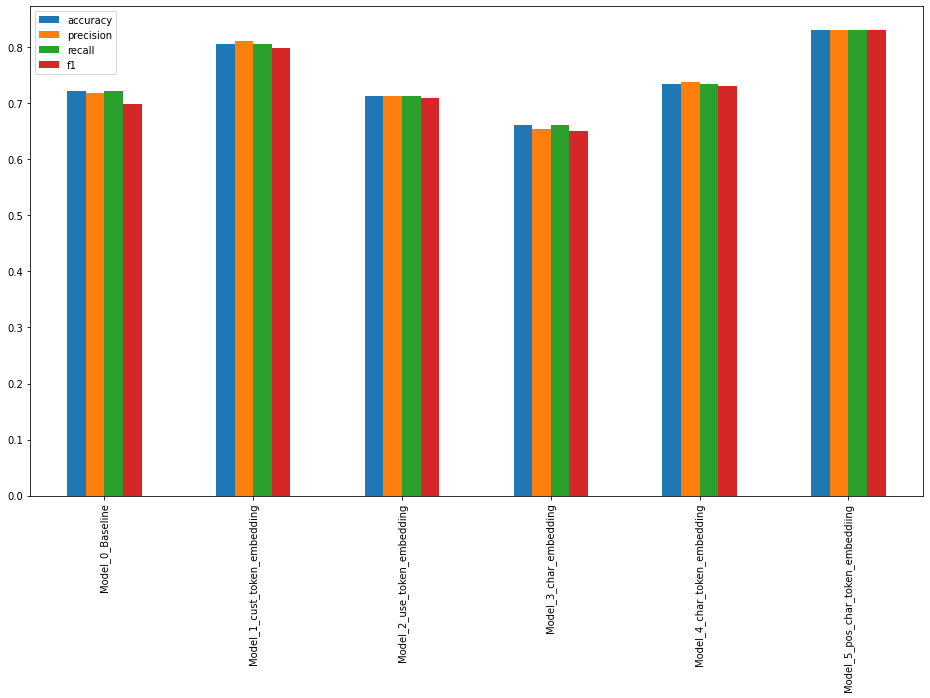

In [ ]:
model_performance_df.plot(kind="bar",figsize=(16,9))

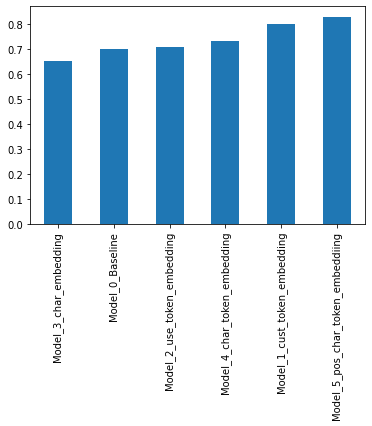

In [ ]:
model_performance_df["f1"].sort_values(ascending=True).plot(kind="bar")

### Save/Load Model
- save and load model that have the best model perforamnce

In [ ]:
model_name = "model_5_pos_token_char_embedding"
model_5.save(model_name)

INFO:tensorflow:Assets written to: model_5_pos_token_char_embedding/assets


INFO:tensorflow:Assets written to: model_5_pos_token_char_embedding/assets


In [ ]:
loaded_model = tf.keras.models.load_model(model_name)
loaded_model_pred = tf.argmax(loaded_model.predict(val_pos_char_token_dataset),axis=1)
loaded_model_result = hf.calculate_results(val_label_encode,loaded_model_pred)
loaded_model_result

{'accuracy': 83.11598040513704,
 'f1': 0.8299344778672504,
 'precision': 0.8304092657820165,
 'recall': 0.8311598040513704}

In [ ]:
model_5_pred_result

{'accuracy': 83.11598040513704,
 'f1': 0.8299344778672504,
 'precision': 0.8304092657820165,
 'recall': 0.8311598040513704}

In [ ]:
assert model_5_pred_result == loaded_model_result

## 2022.07.14 - Exercise
- (v) find the model that have best performance on the testing dataset
- find the wrongest the prediction on the testing dataset from above
- Make prediction on unknown dataset
  - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json
  - https://pubmed.ncbi.nlm.nih.gov/?term=crt
- https://github.com/mrdbourke/tensorflow-deep-learning#-09-milestone-project-2-skimlit--exercises

In [ ]:
model_5_pred_test_prob = model_5.predict(test_pos_char_token_dataset)
model_5_pred_test = tf.argmax(model_5.predict(test_pos_char_token_dataset),axis=1)
model_5_pred_test_result = hf.calculate_results(test_label_encode,model_5_pred_test)
model_5_pred_test_result

{'accuracy': 84.30728388916542,
 'f1': 0.8386748487427285,
 'precision': 0.8466067614003004,
 'recall': 0.8430728388916542}

In [ ]:
test_df["pred_target"]=[class_names[c] for c in model_5_pred_test]
test_df["pred_prob"] = tf.math.reduce_max(model_5_pred_test_prob,axis=1)
test_df.head()

,line_num,target,text,total_lines,ID,pred_target,pred_prob
0,0,BACKGROUND,this study analyzed liver function abnormaliti...,8,24845963,BACKGROUND,0.351100
1,1,RESULTS,a post hoc analysis was conducted with the use...,8,24845963,METHODS,0.436255
2,2,RESULTS,liver function tests ( lfts ) were measured at...,8,24845963,METHODS,0.829703
3,3,RESULTS,survival analyses were used to assess the asso...,8,24845963,METHODS,0.759262
4,4,RESULTS,the percentage of patients with abnormal lfts ...,8,24845963,RESULTS,0.720371


In [ ]:
test_df["correct"] = test_df["target"]==test_df["pred_target"]

In [ ]:
the_most_10_wrong_pred = test_df[test_df["correct"]==False][["text","target","pred_target","pred_prob"]]\
  .sort_values("pred_prob",ascending=False).head(10)

In [ ]:
the_most_10_wrong_pred

,text,target,pred_target,pred_prob
8545,pretest-posttest .,METHODS,BACKGROUND,0.965844
18720,non-diffuse-trickling '' ) .,RESULTS,BACKGROUND,0.965220
1827,nct@ ( clinicaltrials.gov ) .,CONCLUSIONS,BACKGROUND,0.956441
4391,-lsb- netherlands trial register ( http://www....,CONCLUSIONS,BACKGROUND,0.955254
6856,there are currently no therapies to prevent or...,OBJECTIVE,BACKGROUND,0.952504
13874,symptom outcomes will be assessed and estimate...,CONCLUSIONS,METHODS,0.937448
22736,"the national institute of oncology , budapest ...",OBJECTIVE,METHODS,0.926371
25382,"at this time , an as@ response was achieved by...",METHODS,RESULTS,0.921335
26912,( clinicaltrials.gov : nct@ ) .,CONCLUSIONS,BACKGROUND,0.919725
20040,chictr.org .,CONCLUSIONS,BACKGROUND,0.916721


In [ ]:
for row in the_most_10_wrong_pred.itertuples():
  _,text,target,pred_target,pred_prob = row
  print(f"text: {text}")
  print(f"target: {target}, pred_target:{pred_target}, pred_prob:{pred_prob}")
  print("-"*100)

text: pretest-posttest .
target: METHODS, pred_target:BACKGROUND, pred_prob:0.9658437371253967
----------------------------------------------------------------------------------------------------
text: non-diffuse-trickling '' ) .
target: RESULTS, pred_target:BACKGROUND, pred_prob:0.9652202129364014
----------------------------------------------------------------------------------------------------
text: nct@ ( clinicaltrials.gov ) .
target: CONCLUSIONS, pred_target:BACKGROUND, pred_prob:0.9564412832260132
----------------------------------------------------------------------------------------------------
text: -lsb- netherlands trial register ( http://www.trialregister.nl/trialreg/index.asp ) , nr @ , date of registration @ december @ . -rsb-
target: CONCLUSIONS, pred_target:BACKGROUND, pred_prob:0.955254316329956
----------------------------------------------------------------------------------------------------
text: there are currently no therapies to prevent or treat bk virus infe

### Predict unknown dataset

In [ ]:
### pred unknow dataset
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

--2022-07-14 13:32:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-07-14 13:32:39 (58.4 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



In [ ]:
import json
import re
#unknown_data=""
with open("skimlit_example_abstracts.json","r") as f:
  unknown_data = json.load(f)
#list(map(lambda x:re.sub("[0-9]","@",x["abstract"]),unknown_data))
unknown_data = list(map(lambda x:x["abstract"],unknown_data))
unknown_data

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
 "Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth. No sing

In [ ]:
sentence_3 = unknown_data[3]

In [ ]:
new_sentence=""
for ind,ch in enumerate(sentence_3):
  if ind==len(sentence_3)-2:
    break
  if ch=='.' and  not sentence_3[ind+2].isupper():
    ch = "#"
  new_sentence+=ch
unknown_data[3] = new_sentence

In [ ]:
unknown_sentence_data = list(map(lambda x:x.split("."),unknown_data))
test_unknown_data = []
for id,li in enumerate(unknown_sentence_data):
  total_line_num = len(li)-1-1 # exclute "" and convert to index for line_number
  for line_num, substr in enumerate(li):
    temp_text_data = dict()
    if len(substr) > 0:
      processed_str = substr.strip().replace("#",".")+"."
      processed_str = re.sub("[0-9]","@",processed_str)
      temp_text_data["id"] = id
      temp_text_data["text"] = processed_str
      temp_text_data["line_num"] = line_num
      temp_text_data["total_line_num"] = total_line_num
      
      test_unknown_data.append(temp_text_data)
test_unknown_df = pd.DataFrame(test_unknown_data)

In [ ]:
# feature engineeing and prepare tf.data.Dataset
test_unknown_sentence = test_unknown_df["text"].to_numpy()
test_unknown_char = [split_chars(c) for c in test_unknown_df["text"].to_numpy()]
test_unknown_line_num_one_hot = tf.one_hot(test_unknown_df["line_num"].to_numpy(),depth=15)
test_unknown_total_line_one_hot = tf.one_hot(test_unknown_df["total_line_num"].to_numpy(),depth=20)

In [ ]:
test_unknown_data = tf.data.Dataset.from_tensor_slices((test_unknown_sentence,
                                                        test_unknown_char,
                                                        test_unknown_line_num_one_hot,
                                                        test_unknown_total_line_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# can convert numpy then execute predict
test_unknown_pred = model_5.predict((test_unknown_sentence,
                 np.array(test_unknown_char),
                 test_unknown_line_num_one_hot.numpy(),
                 test_unknown_total_line_one_hot.numpy()),verbose=1)

2/2 [==============================] - 0s 37ms/step


In [ ]:
test_unknown_df["pred_class"] = [class_names[c] for c in tf.argmax(test_unknown_pred,axis=1)]

In [ ]:
def assign_ind(row):
  map_dict={
      "BACKGROUND":0,
      "OBJECTIVE":1,
      "METHODS":2,
      "RESULTS":3,
      "CONCLUSIONS":4
  }
  return map_dict[row]

In [ ]:
test_unknown_df["pred_class_order"] = test_unknown_df["pred_class"].apply(assign_ind)

In [ ]:
test_unknown_df.sort_values(["id","pred_class_order"],ascending=True,inplace=True)

In [ ]:
# re-combine the text based on the predict_class 
pred_class_indicator=""
for id in  range(len(test_unknown_df["id"].value_counts())):
  print(f"{'*'*50+str(id)+'*'*50}")
  for _,text,pred_class in test_unknown_df[test_unknown_df["id"]==id][["text","pred_class"]].itertuples():
    if pred_class_indicator != pred_class:
      print("-"*100)
      print(pred_class,":")
      pred_class_indicator = pred_class
    print(f"{text}")

**************************************************0**************************************************
----------------------------------------------------------------------------------------------------
OBJECTIVE :
This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
----------------------------------------------------------------------------------------------------
METHODS :
Participants were randomly assigned to treatment or wait-list conditions.
Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
----------------------------------------------------------------------------------------------------
RESULTS :
Significant treatment e

### Model 5 training with Callbacks
- ModelCheckpoint
- EarlyStopping

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("./model_checkpoint",
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)
early_stopping_checkpoint = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                             patience=1)

### Bert Embedding

In [ ]:
!pip install --quiet "tensorflow-text==2.8.2"

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text 

In [ ]:
## utiilize the BERT
preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',name="bert_preprocess")
bert = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2',name="bert")

In [ ]:
bert(preprocess([train_sentence[0]]),training=False)["pooled_output"].shape

TensorShape([1, 768])

### Feature engineering Combine the linenum_totallines
- combine line num and total_line_number

In [ ]:
train_df["combined_line"] = train_df["line_num"].astype(str)+"_"+train_df["total_lines"].astype(str)
map_dict_ = train_df["combined_line"].value_counts().rank(ascending=False, method="first").astype(int).to_dict()
def assign_freq_order(row):
  global map_dict_
  return map_dict_[row]

In [ ]:
train_df["combined_line_freq_order"] = train_df["combined_line"].apply(assign_freq_order)
combinned_line_num_one_hot_n = int(np.percentile(train_df["combined_line_freq_order"],95))
train_combine_line_one_hot = tf.one_hot(train_df["combined_line_freq_order"],depth=combinned_line_num_one_hot_n)

val_df["combined_line"] = val_df["line_num"].astype(str)+"_"+val_df["total_lines"].astype(str)
val_df["combined_line_freq_order"] = val_df["combined_line"].apply(assign_freq_order)
val_combine_line_one_hot = tf.one_hot(val_df["combined_line_freq_order"],depth=combinned_line_num_one_hot_n)

test_df["combined_line"] = test_df["line_num"].astype(str)+"_"+test_df["total_lines"].astype(str)
test_df["combined_line_freq_order"] = test_df["combined_line"].apply(assign_freq_order)
test_combine_line_one_hot = tf.one_hot(test_df["combined_line_freq_order"],depth=combinned_line_num_one_hot_n)

In [ ]:
### Modeling
# token model
token_inputs = tf.keras.layers.Input(shape=[],dtype=tf.string)
#token_embeddings = use(token_inputs)
token_embeddings = preprocess(token_inputs)
token_embeddings = bert(token_embeddings,training=False)
token_outputs = tf.keras.layers.Dense(128,activation="relu")(token_embeddings["pooled_output"])
token_model = tf.keras.Model(token_inputs,
                             token_outputs,
                             name="token_model")

# char model
char_inputs = tf.keras.layers.Input(shape=[1],dtype=tf.string)
char_vectors = char_vectorizer(char_inputs)
x = char_embeddings(char_vectors)
char_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(x)
char_model =tf.keras.Model(char_inputs,
                           char_outputs,
                           name="char_model")
# line num model
"""
line_number_inputs = tf.keras.layers.Input(shape=[15],dtype=tf.float32)
line_number_outputs = tf.keras.layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,
                                          line_number_outputs,
                                          name="line_number_model")
# total line num model
total_line_inputs = tf.keras.layers.Input(shape=[20],dtype=tf.float32)
total_line_outputs = tf.keras.layers.Dense(32,activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs,
                                          total_line_outputs,
                                         name="total_line_model")
"""
combine_line_number_inputs = tf.keras.layers.Input(shape=[161],dtype=tf.float32)
combine_line_number_outputs = tf.keras.layers.Dense(32,activation="relu")(combine_line_number_inputs)
combine_line_number_model = tf.keras.Model(combine_line_number_inputs,
                                          combine_line_number_outputs,
                                          name="combine_line_number_model")


# combine token and char outputs
combined_embedding = tf.keras.layers.concatenate([char_outputs,token_outputs])
z = tf.keras.layers.Dense(256,activation="relu")(combined_embedding)
z = tf.keras.layers.Dropout(0.5)(z)

# combinne (token+char) outptus and line and total
pos_char_token_embedding = tf.keras.layers.concatenate([z,
                                                        combine_line_number_outputs])

outputs = tf.keras.layers.Dense(len(class_names),activation="softmax")(pos_char_token_embedding)
model_5 = tf.keras.Model([token_model.input,
                          char_model.input,
                          combine_line_number_model.input],
                         outputs,
                         name="tribid_embedding_modoel")

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


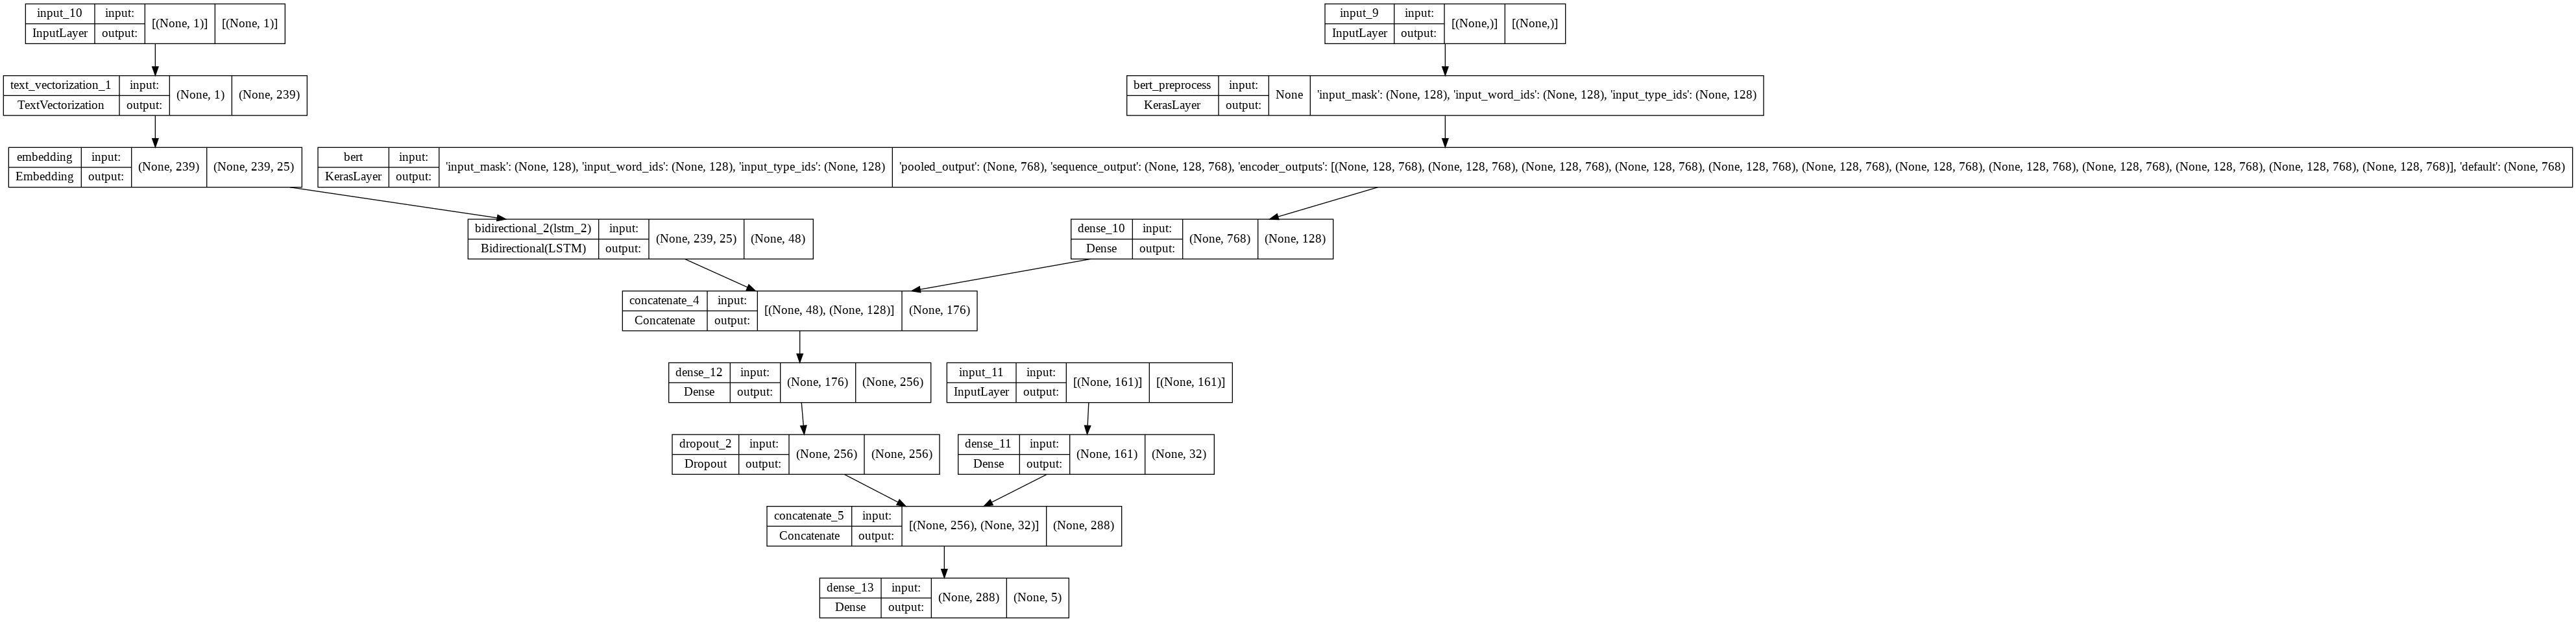

In [ ]:
plot_model(model_5,show_shapes=True)

In [ ]:
# train
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentence,
                                                                train_chars_sentence,
                                                                train_combine_line_one_hot
                                                                ))
train_pos_char_token_label = tf.data.Dataset.from_tensor_slices(train_label_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data,train_pos_char_token_label)).batch(32).prefetch(tf.data.AUTOTUNE)


#val
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentence,
                                                                val_chars_sentence,
                                                                val_combine_line_one_hot
                                                                ))
val_pos_char_token_label = tf.data.Dataset.from_tensor_slices(val_label_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data,val_pos_char_token_label)).batch(32).prefetch(tf.data.AUTOTUNE)


#test
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentence,
                                                                test_chars_sentence,
                                                                test_combine_line_one_hot,
                                                                ))
test_pos_char_token_label = tf.data.Dataset.from_tensor_slices(test_label_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data,test_pos_char_token_label)).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
### line_num_total_line feature is perfomed far worse than spearate one 
history_5_exe = model_5.fit(
    train_pos_char_token_dataset,
    steps_per_epoch = int(0.05*len(train_pos_char_token_dataset)),
    epochs = 1,
    validation_data = val_pos_char_token_dataset,
    validation_steps = int(0.05*len(val_pos_char_token_dataset)),
    verbose = 1,
    callbacks = [model_checkpoint,
                 early_stopping_checkpoint]
)

281/281 [==============================] - ETA: 0s - loss: 0.6736 - accuracy: 0.7580
Epoch 1: val_accuracy did not improve from 0.87832
281/281 [==============================] - 128s 422ms/step - loss: 0.6736 - accuracy: 0.7580 - val_loss: 0.5016 - val_accuracy: 0.8298


## Review

### Summarize the input and outputs

In [31]:
# prepare the data
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(dev_data)
test_df = pd.DataFrame(test_data)

In [62]:
# for token dataset
train_token_sentence = train_df["text"].to_numpy()
val_token_sentence = val_df["text"].to_numpy()
test_token_sentence = test_df["text"].to_numpy()

In [63]:
# for character dataset
train_char_sentence = list(map(split_chars,train_df["text"].to_numpy()))
val_char_sentence = list(map(split_chars,val_df["text"].to_numpy()))
test_char_sentence = list(map(split_chars,test_df["text"].to_numpy()))

In [47]:
# for line number to determine the depth of one hot, like the way to determine the output_sequence length in the text vectorization
train_line_num = tf.one_hot(train_df["line_num"],np.percentile(train_df["line_num"],95))
val_line_num = tf.one_hot(val_df["line_num"],np.percentile(train_df["line_num"],95))
test_line_num = tf.one_hot(test_df["line_num"],np.percentile(train_df["line_num"],95))

In [50]:
# for total_line number to determine the depth of one hot, like the way to determine the output_sequence length in the text vectorization
train_total_line_num = tf.one_hot(train_df["total_lines"],np.percentile(train_df["total_lines"],95))
val_total_line_num = tf.one_hot(val_df["total_lines"],np.percentile(train_df["total_lines"],95))
test_total_line_num = tf.one_hot(test_df["total_lines"],np.percentile(train_df["total_lines"],95))

In [55]:
# for taget label
one_hot_encoder = OneHotEncoder(sparse=False)
train_label_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_label_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_label_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

In [94]:
#train_token_sentence.shape,train_char_sentence.shape, 
train_line_num.shape, train_total_line_num.shape, train_label_one_hot.shape

(TensorShape([180040, 13]), TensorShape([180040, 18]), (180040, 5))

In [56]:
# feature engineering for token and text vectorization

In [58]:
from tensorflow.keras.layers import TextVectorization

In [66]:
token_output_length =  int(np.percentile(train_df["text"].str.split(" ").apply(lambda x:len(x)),95))

In [65]:
# word text vectorizer 
token_vectorizer = TextVectorization(
    max_tokens = 68000,
    output_sequence_length = int(np.percentile(train_df["text"].str.split(" ").apply(lambda x:len(x)),95))
)
token_vectorizer.adapt(train_token_sentence)

In [86]:
token_embedding = Embedding(
    input_dim = len(token_vectorizer.get_vocabulary()),
    output_dim = 128,
    input_length = token_output_length
)

In [74]:
char_output_length = np.percentile(list(map(lambda x:len(x.split(" ")),train_char_sentence)),95)
char_output_length

342.0

In [76]:
import string
len(string.ascii_lowercase) + len(string.digits) + len(string.punctuation)

68

In [92]:
# char text vectorizer 
char_vectorizer = TextVectorization(
    max_tokens = 68 + 2,
    output_sequence_length = int(char_output_length)
)
char_vectorizer.adapt(train_char_sentence)

char_embedding = Embedding(
    input_dim = len(char_vectorizer.get_vocabulary()) + 1,
    output_dim = 128,
    input_length = char_output_length
)

In [84]:
train_total_line_num.shape

TensorShape([180040, 18])

In [112]:
import tensorflow_hub as hub

In [117]:
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
                              trainable = False)

FileNotFoundError: ignored

In [116]:
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=False)

In [137]:
### Multi-Input model
token_inputs = tf.keras.layers.Input(shape=[],dtype=tf.string)
token_vector = token_vectorizer(token_inputs)
token_embed = token_embedding(token_vector)
token_x = tf.keras.layers.GlobalAveragePooling1D()(token_embed)
token_outputs = tf.keras.layers.Dense(128,activation="relu")(token_x)
token_model = tf.keras.Model(token_inputs,
                             token_outputs)

##
char_inputs = tf.keras.layers.Input(shape=[],dtype=tf.string)
char_vector = char_vectorizer(char_inputs)
char_embed = char_embedding(char_vector)
char_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(char_embed)
char_model = tf.keras.Model(char_inputs,char_outputs)

## 
line_inputs = tf.keras.layers.Input(shape=[13])
line_outputs = tf.keras.layers.Dense(128,activation="relu")(line_inputs)
line_model = tf.keras.Model(line_inputs,line_outputs)

total_line_inputs = tf.keras.layers.Input(shape=[18])
total_line_outputs = tf.keras.layers.Dense(128,activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs,total_line_outputs)


combine_char_token = tf.keras.layers.concatenate([token_outputs,char_outputs])
z = tf.keras.layers.Dropout(0.5)(combine_char_token)
z = tf.keras.layers.Dense(128,activation="relu")(z)
z = tf.keras.layers.Dropout(0.5)(z)

combine_all = tf.keras.layers.concatenate([z,
                              total_line_outputs,
                              line_outputs])


outputs = tf.keras.layers.Dense(5,activation="sigmoid")(combine_all)
model = tf.keras.Model([token_model.inputs,
                        char_model.inputs,
                        line_model.inputs,
                        total_line_model.inputs,
                        ],outputs)


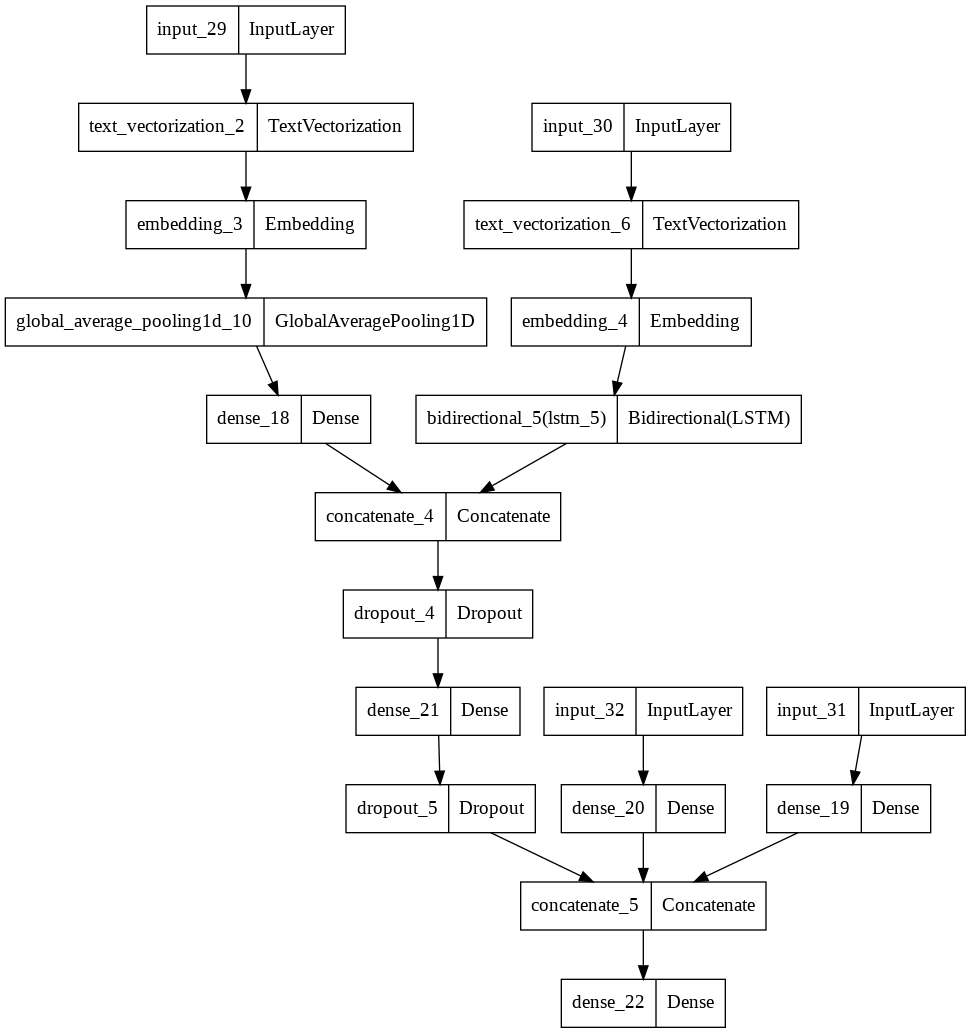

In [138]:
plot_model(model)

In [102]:
### Tensorflow Dataset
train_data_dataset = tf.data.Dataset.from_tensor_slices((train_token_sentence,
                                                          train_char_sentence,
                                                          train_line_num,
                                                          train_total_line_num))
train_data_label = tf.data.Dataset.from_tensor_slices(train_label_one_hot)
train_dataset = tf.data.Dataset.zip((train_data_dataset,train_data_label)).batch(32).prefetch(tf.data.AUTOTUNE)

val_data_dataset = tf.data.Dataset.from_tensor_slices((val_token_sentence,
                                                          val_char_sentence,
                                                          val_line_num,
                                                          val_total_line_num))
val_data_label = tf.data.Dataset.from_tensor_slices(val_label_one_hot)
val_dataset = tf.data.Dataset.zip((val_data_dataset,val_data_label)).batch(32).prefetch(tf.data.AUTOTUNE)

test_data_dataset = tf.data.Dataset.from_tensor_slices((test_token_sentence,
                                                          test_char_sentence,
                                                          test_line_num,
                                                          test_total_line_num))
test_data_label = tf.data.Dataset.from_tensor_slices(test_label_one_hot)
test_dataset = tf.data.Dataset.zip((test_data_dataset,test_data_label)).batch(32).prefetch(tf.data.AUTOTUNE)

In [103]:
len(train_data_dataset)

180040

In [139]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [140]:
### Training
history = model.fit(train_dataset,
              epochs = 3,
              steps_per_epoch = int(0.3*len(train_dataset)),
              validation_data = val_dataset,
              validation_steps = int(0.3*len(val_dataset)))

Epoch 1/3
1688/1688 [==============================] - 61s 34ms/step - loss: 0.9259 - accuracy: 0.8500 - val_loss: 0.8953 - val_accuracy: 0.8498
Epoch 2/3
1688/1688 [==============================] - 56s 33ms/step - loss: 0.8730 - accuracy: 0.8847 - val_loss: 0.8884 - val_accuracy: 0.8576
Epoch 3/3
1688/1688 [==============================] - 58s 35ms/step - loss: 0.8640 - accuracy: 0.8894 - val_loss: 0.8979 - val_accuracy: 0.8555


In [110]:
### Evaluation
model.evaluate(test_dataset)

942/942 [==============================] - 11s 11ms/step - loss: 0.3752 - accuracy: 0.8603


[0.3751668334007263, 0.8603284955024719]

In [142]:
model.save("total.tf")

INFO:tensorflow:Assets written to: total.tf/assets


INFO:tensorflow:Assets written to: total.tf/assets


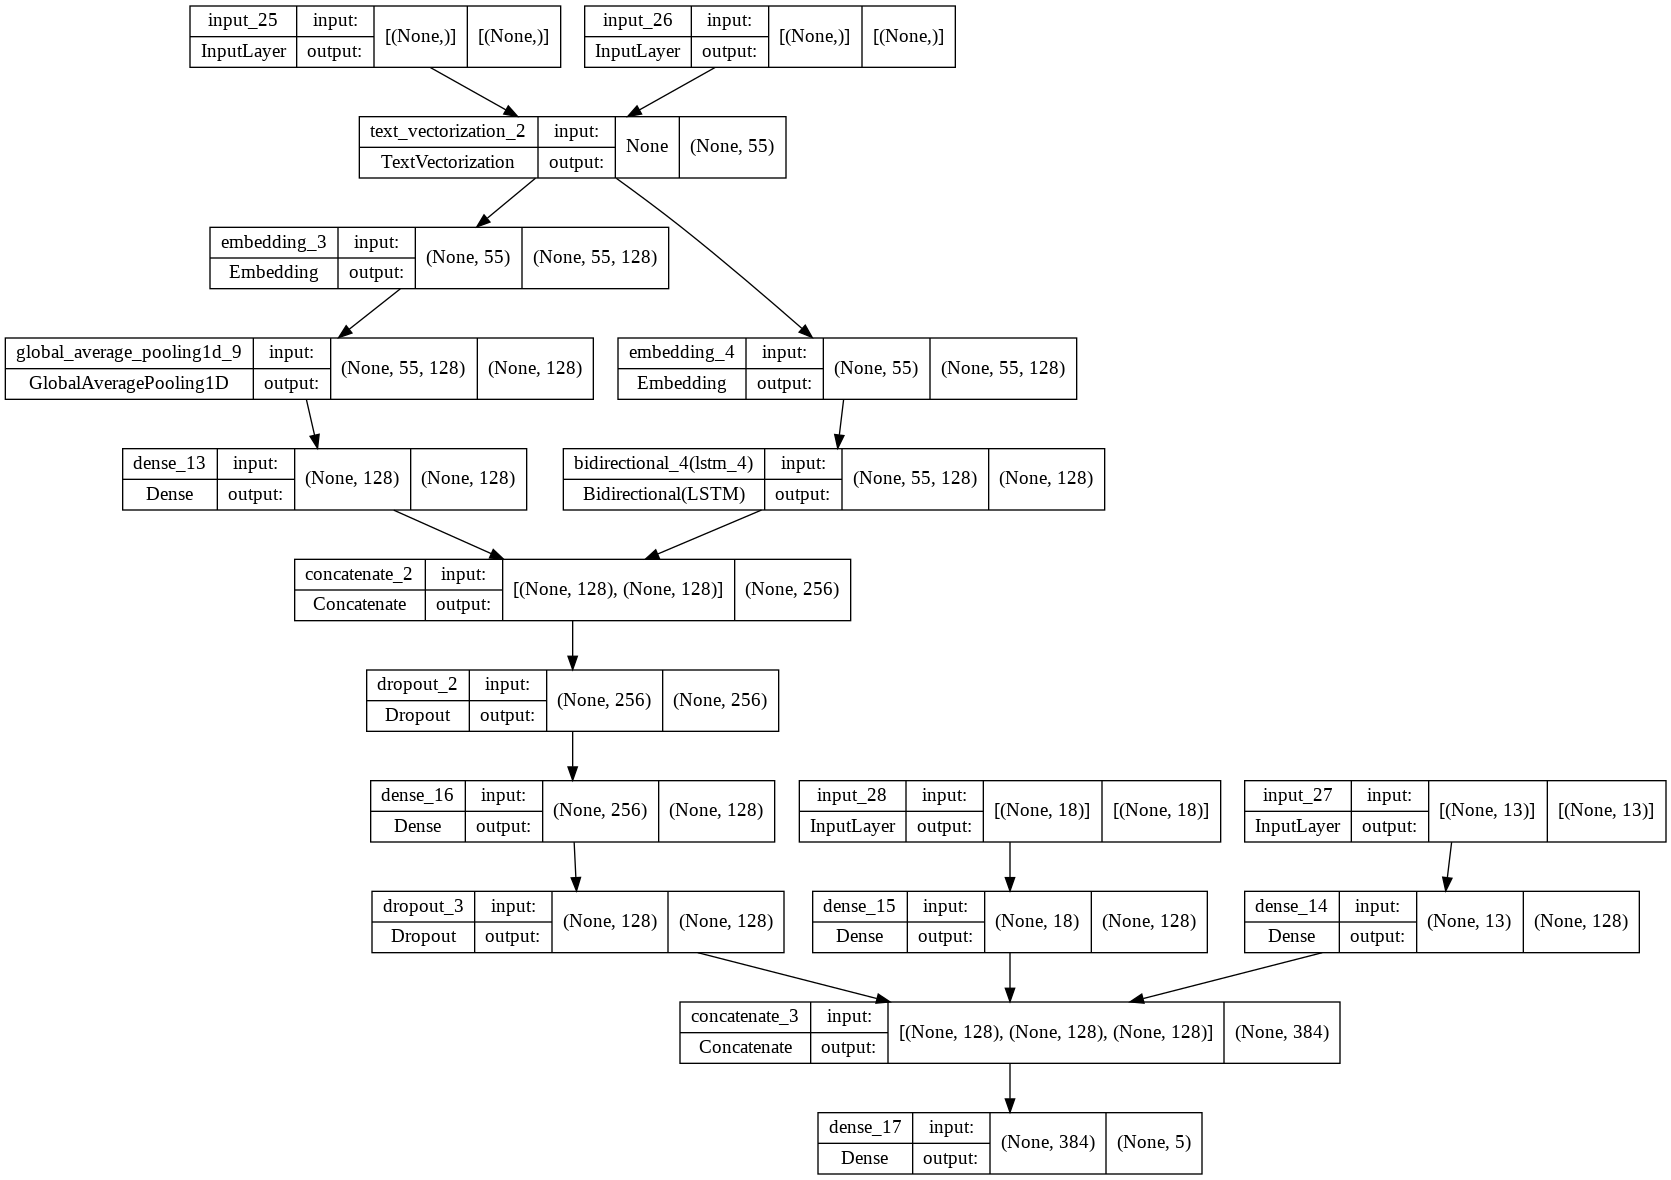

In [136]:
plot_model(model,show_shapes=True)

In [135]:
model.layers

In [125]:
model.save_weights("total")

In [127]:
clone_model = tf.keras.models.clone_model(model)

In [128]:
clone_model.load_weights("total")

In [143]:
!echo $CUSTOM_PATH/tensorflow_core/python/keras/saving/hdf5_format.py

/tensorflow_core/python/keras/saving/hdf5_format.py


In [144]:
!cat /tensorflow_core/python/keras/saving/hdf5_format.py

cat: /tensorflow_core/python/keras/saving/hdf5_format.py: No such file or directory
